In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

Verilerin Okunması

In [4]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [5]:
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


EDA

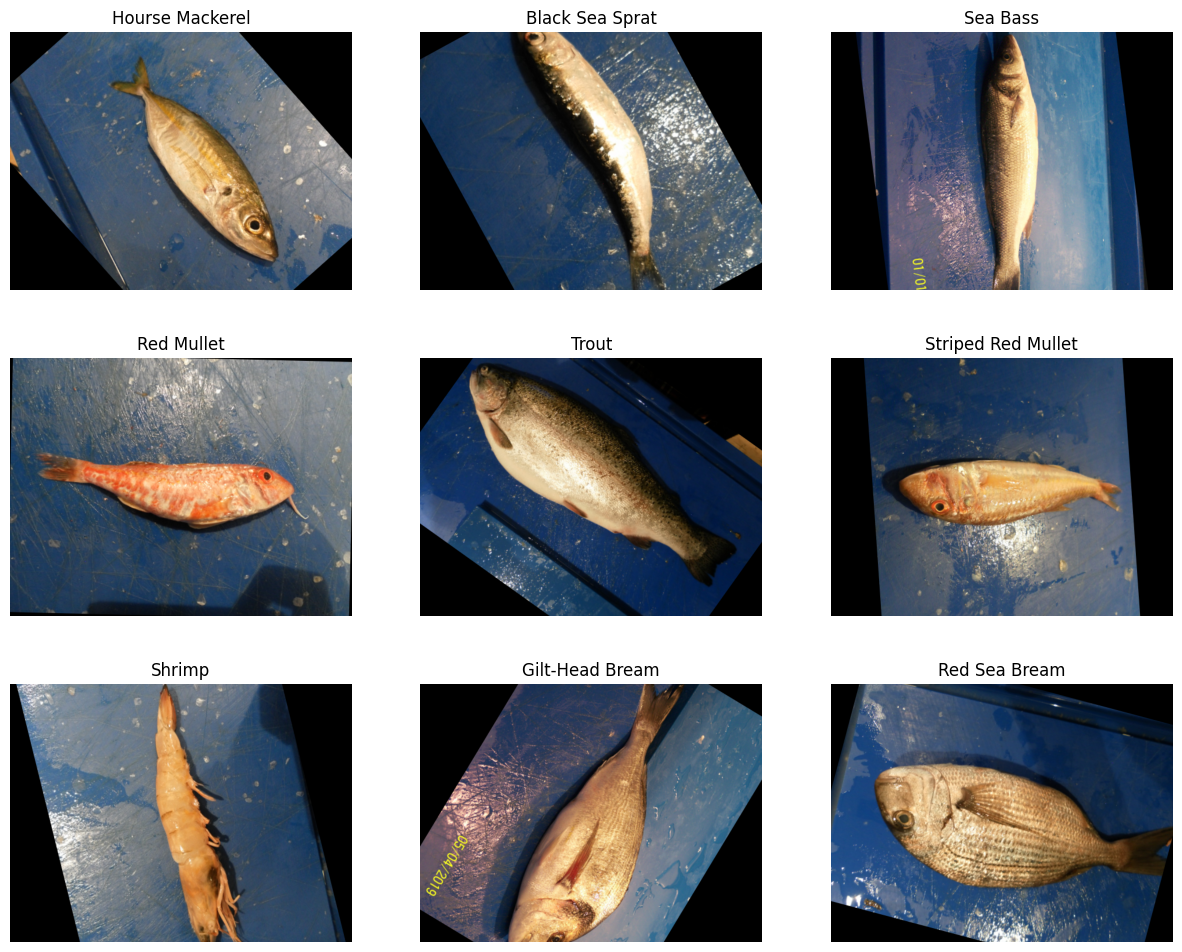

In [6]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

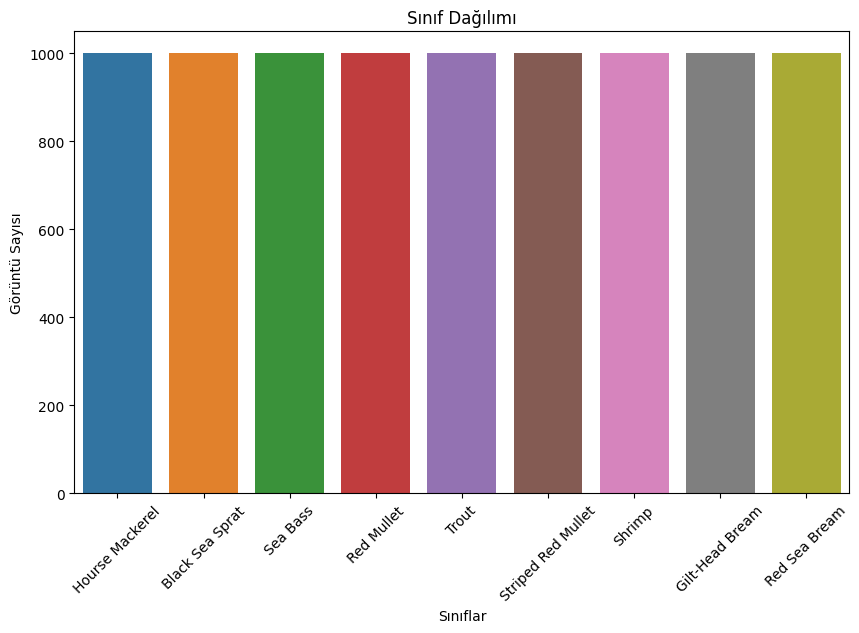

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45)  
plt.show()

Veri Ön İşleme

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,    
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2    
)

test_generator = ImageDataGenerator(rescale=1./255)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential()

# Model katmanlarını ekleyelim.

# Input Layer
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# Hidden Layers
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))


#Output Layer
model.add(tf.keras.layers.Dense(9, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,113,481 (11.88 MB)

 Trainable params: 3,110,409 (11.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall', 'F1Score'],              
)

In [15]:
results = model.fit(
    train_images, 
    epochs=5, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping,lr_scheduler_callback]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 876ms/step - F1Score: 0.9474 - accuracy: 0.9481 - loss: 2.6400 - precision: 0.9589 - recall: 0.9405 - val_F1Score: 0.9175 - val_accuracy: 0.9181 - val_loss: 2.7192 - val_precision: 0.9281 - val_recall: 0.9056 - learning_rate: 0.0100
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 858ms/step - F1Score: 0.9578 - accuracy: 0.9579 - loss: 2.5998 - precision: 0.9655 - recall: 0.9510 - val_F1Score: 0.9344 - val_accuracy: 0.9347 - val_loss: 2.6493 - val_precision: 0.9433 - val_recall: 0.9243 - learning_rate: 0.0100
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 867ms/step - F1Score: 0.9630 - accuracy: 0.9632 - loss: 2.5568 - precision: 0.9668 - recall: 0.9564 - val_F1Score: 0.9267 - val_accuracy: 0.9271 - val_loss: 2.6445 - val_precision: 0.9337 - val_recall: 0.9194 - learning_rate: 0.0100
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 857ms/step - F1Score: 0.9653 - accuracy: 0.9654 - loss: 2.5280 - precision: 0.9714 - recall: 0.9612 - val_F1Score: 0.9191 - val_accuracy:

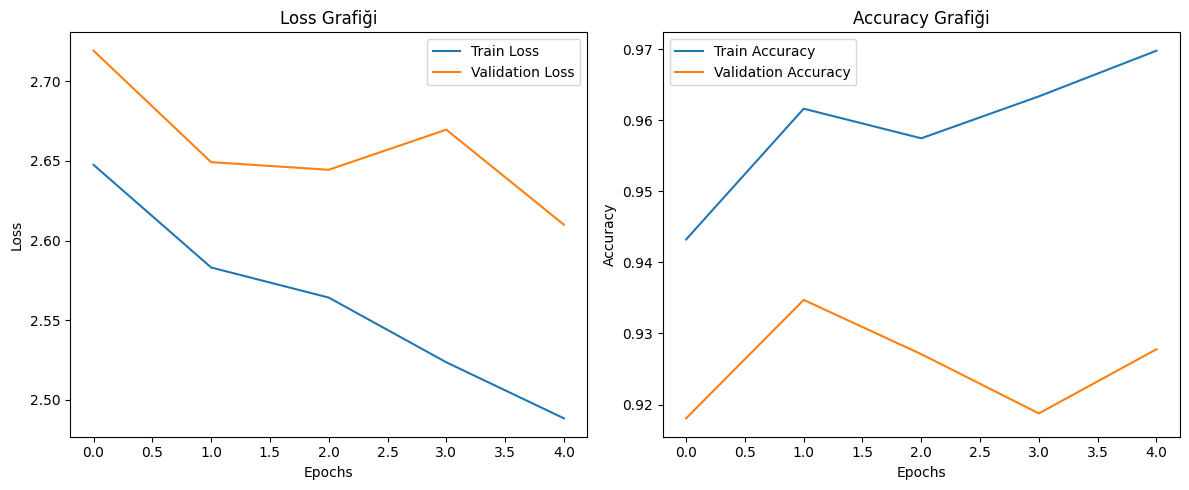

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Loss değeri için grafikleri çizdirelim.
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model Değerlendirmesi

In [17]:
import numpy as np

pred = model.predict(test_images)
pred_classes = np.argmax(pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


In [18]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images)

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 733ms/step - F1Score: 0.9118 - accuracy: 0.9115 - loss: 2.6902 - precision: 0.9202 - recall: 0.9039


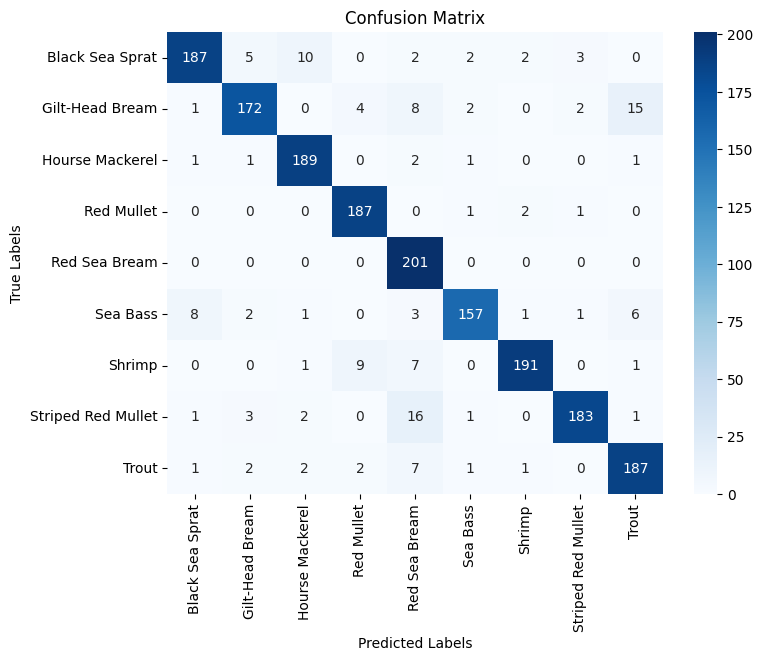

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = test_images.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alın
class_labels = list(test_images.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Test verisinin sınıflandırma raporu

In [20]:
print(classification_report(true_classes, pred_classes, target_names=class_labels))


                    precision    recall  f1-score   support

   Black Sea Sprat       0.94      0.89      0.91       211
   Gilt-Head Bream       0.93      0.84      0.88       204
   Hourse Mackerel       0.92      0.97      0.95       195
        Red Mullet       0.93      0.98      0.95       191
     Red Sea Bream       0.82      1.00      0.90       201
          Sea Bass       0.95      0.88      0.91       179
            Shrimp       0.97      0.91      0.94       209
Striped Red Mullet       0.96      0.88      0.92       207
             Trout       0.89      0.92      0.90       203

          accuracy                           0.92      1800
         macro avg       0.92      0.92      0.92      1800
      weighted avg       0.92      0.92      0.92      1800



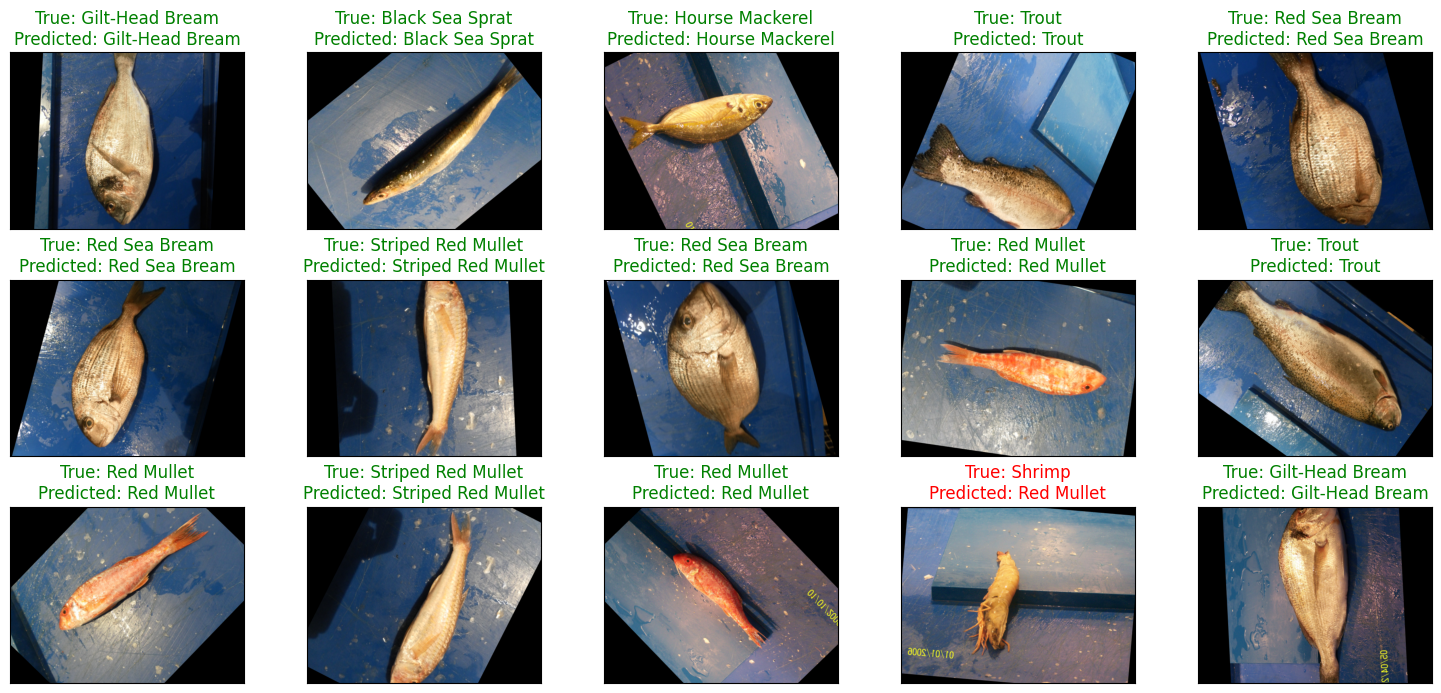

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[i]))
    if test_images.labels[i] == pred_classes[i]:
        color = 'green'  
    else:
        color = 'red'    
    ax.set_title(f"True: {class_labels[test_images.labels[i]]}\nPredicted: {class_labels[pred_classes[i]]}", color = color)  

plt.tight_layout()
plt.show()